In [6]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import copy 
import src.update 

import tqdm

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from src.update import LocalUpdate
from monai.utils import set_determinism
from src.utils import get_dataset,average_weights

import torch

print_config()

MONAI version: 0.5.2+24.g2a4c9e5
Numpy version: 1.19.2
Pytorch version: 1.8.0a0+52ea372
MONAI flags: HAS_EXT = True, USE_COMPILED = False
MONAI rev id: 2a4c9e514bbc603191e49120e9d598a9414c0e75

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.15.0
Pillow version: 8.2.0
Tensorboard version: 1.15.0+nv
gdown version: 3.13.0
TorchVision version: 0.9.0a0
ITK version: 5.1.2
tqdm version: 4.53.0
lmdb version: 1.1.1
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [31]:
#from tensorboardX import SummaryWriter

path_project = os.path.abspath('..')
#logger = SummaryWriter('../logs')
logger=0
os.environ["MONAI_DATA_DIRECTORY"]="/data"  
root_dir = os.environ.get("MONAI_DATA_DIRECTORY")

#args = args_parser()
epochs = 80
num_users = 1
frac = 1 
local_ep = 1
local_bs = 2
lr = 1e-4
momentum = 0.5
iid=1
dataset="brats"
#exp_details(args)

device = torch.device("cuda:0")



In [32]:
print(local_ep)

1


In [33]:
set_determinism(seed=0)

In [34]:
import importlib
import src.utils
importlib.reload(src.utils)
from src.utils import get_dataset

In [18]:
#Load Datasets
train_dataset, val_dataset, user_groups_train, user_groups_val = get_dataset(iid, num_users, download_dataset=True)


Task01_BrainTumour.tar: 0.00B [00:00, ?B/s]

/data


Task01_BrainTumour.tar: 7.09GB [21:44, 5.83MB/s]                                



downloaded file: /data/Task01_BrainTumour.tar.
Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.


Loading dataset:   0%|          | 0/96 [00:00<?, ?it/s]

Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
file /data/Task01_BrainTumour.tar exists, skip downloading.
extracted file /data/Task01_BrainTumour exists, skip extracting.


Loading dataset: 100%|██████████| 96/96 [02:01<00:00,  1.26s/it]


96


In [19]:
for key,value in user_groups_train.items():
    print(key,value)
for key,value in user_groups_val.items():
    print(key,value)
#print(len(train_dataset))

0 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

In [20]:
print(f"image shape: {train_dataset[2]['image'].shape}")
print(type(train_dataset[2]['image']))

image shape: torch.Size([4, 128, 128, 64])
<class 'torch.Tensor'>


In [35]:

#Build model
global_model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


In [36]:
import importlib
import src.update
importlib.reload(src.update)
from src.update import LocalUpdate
import src.utils
importlib.reload(src.utils)
from src.utils import average_weights
import time 

In [37]:
start = time.time()

In [ ]:
##### global_model.to(device)
global_model.train()

#print(global_model)

# copy weights
global_weights = global_model.state_dict()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0


#####
best_metric = -1
best_metric_epoch = -1
#epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

metric, metric_tc, metric_wt, metric_et=0.0,0.0,0.0,0.0


In [51]:
epochs = 20

In [52]:


for epoch in tqdm.tqdm(range(epochs)):
        
    local_weights, local_losses = [], []
    
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)

    for idx in idxs_users:
        
        print(f"user {idx} selected")
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                  train_idxs=user_groups_train[idx],val_idxs=user_groups_val[idx], logger=logger, local_bs=local_bs, lr=lr, local_ep=local_ep)
        w, loss = local_model.update_weights(
                model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(w))
      #  local_losses.append(copy.deepcopy(loss))
        local_losses.append(loss)
     #   global_model.load_state_dict(copy.deepcopy(w))
    
     #   global_model.eval()
        
     #   local_model.inference(model=global_model)

    # update global weights
    global_weights = average_weights(local_weights)
   ## global_weights = local_weights[0]
    
    # update global loss
    global_model.load_state_dict(global_weights)
    
    for c in range(num_users):
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
        local_model.inference(model=global_model)
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    print(f"current epoch: {epoch + 1} current epoch loss: {loss_avg:.4f}")
    # Calculate avg training accuracy over all users at every epoch
    
   # list_acc, list_loss = [], []
    ep_metric_values = []
    ep_metric_values_tc = []
    ep_metric_values_wt = []
    ep_metric_values_et = []

    for c in range(num_users):
        local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
        metric, metric_tc, metric_wt, metric_et=local_model.inference(model=global_model)
        
        ep_metric_values.append(metric)
        ep_metric_values_tc.append(metric_tc)
        ep_metric_values_wt.append(metric_wt) 
        ep_metric_values_et.append(metric_et) 

    metric = sum(ep_metric_values)/len(ep_metric_values)
    metric_tc = sum(ep_metric_values_tc)/len(ep_metric_values_tc)
    metric_wt = sum(ep_metric_values_wt)/len(ep_metric_values_wt)
    metric_et = sum(ep_metric_values_et)/len(ep_metric_values_et)
    metric_values.append(metric)
    metric_values_tc.append(metric_tc)
    metric_values_wt.append(metric_wt)
    metric_values_et.append(metric_et)

    global_model.eval()
  ###  for c in range(num_users):
  ###      local_model = LocalUpdate(train_dataset=train_dataset, val_dataset=val_dataset,
  ###                                    train_idxs=user_groups_train[c],val_idxs=user_groups_val[c], logger=logger, lr=lr, local_ep=local_ep, local_bs=local_bs)
  ###      metric, metric_tc, metric_wt, metric_et = local_model.inference(model=global_model)
         
   ##    print(metric)
   ##    ep_metric_values.append(metric)
   ##     ep_metric_values_tc.append(metric_tc)
   ##     ep_metric_values_wt.append(metric_wt) 
   ##     ep_metric_values_et.append(metric_et) 

        
   # train_accuracy.append(sum(list_acc)/len(list_acc))
##    metric = sum(ep_metric_values)/len(ep_metric_values)
    print(metric)
##    metric_tc = sum(ep_metric_values_tc)/len(ep_metric_values_tc)
##    metric_wt = sum(ep_metric_values_wt)/len(ep_metric_values_wt)
##    metric_et = sum(ep_metric_values_et)/len(ep_metric_values_et)
##    metric_values.append(metric)
##    metric_values_tc.append(metric_tc)
##    metric_values_wt.append(metric_wt)
##    metric_values_et.append(metric_et)
    
    if metric > best_metric:
         
        best_metric = metric
        best_metric_epoch = epoch + 1
        torch.save(
                global_model.state_dict(),
                os.path.join(root_dir, "best_metric_model.pth"),
        )
        
     #   torch.save({
      #      'epoch': epoch + 1,
       #     'model_state_dict': model.state_dict(),
        #    'optimizer_state_dict':  optimizer = torch.optim.Adam(model.parameters(), lr=self.lr,
         #                               weight_decay=1e-5, amsgrad=True),
          #  'loss': loss,
          #  ...
           # }, root_dir)
        
        print("saved new best metric model")


    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
      #  print(f' \nAvg Training Stats after {epoch+1} global rounds:')
      #  print(f'Training Loss : {np.mean(np.array(train_loss))}')
      #  print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
         print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
            f"\nbest mean dice: {best_metric:.4f}"
            f" at epoch: {best_metric_epoch}"
         )



  0%|          | 0/20 [00:00<?, ?it/s]


 | Global Training Round : 1 |

user 0 selected
local epoch 1
1/194, train_loss: 0.8032
2/194, train_loss: 0.6410
3/194, train_loss: 0.7789
4/194, train_loss: 0.6724
5/194, train_loss: 0.8163
6/194, train_loss: 0.7257
7/194, train_loss: 0.9074
8/194, train_loss: 0.7650
9/194, train_loss: 0.7262
10/194, train_loss: 0.6547
11/194, train_loss: 0.8094
12/194, train_loss: 0.7305
13/194, train_loss: 0.7035
14/194, train_loss: 0.7613
15/194, train_loss: 0.8024
16/194, train_loss: 0.7700
17/194, train_loss: 0.6130
18/194, train_loss: 0.8504
19/194, train_loss: 0.7974
20/194, train_loss: 0.7632
21/194, train_loss: 0.7981
22/194, train_loss: 0.7536
23/194, train_loss: 0.8091
24/194, train_loss: 0.7559
25/194, train_loss: 0.7429
26/194, train_loss: 0.8382
27/194, train_loss: 0.6037
28/194, train_loss: 0.7747
29/194, train_loss: 0.7072
30/194, train_loss: 0.6862
31/194, train_loss: 0.7637
32/194, train_loss: 0.9704
33/194, train_loss: 0.7729
34/194, train_loss: 0.8295
35/194, train_loss: 0.8674
3

  5%|▌         | 1/20 [09:42<3:04:35, 582.90s/it]

metric=0.3584009117136399, metric_tc=0.37438743825381, metric_wt=0.49291782764097053, metric_et=0.2078974770459657
0.3584009117136399
current epoch: 1 current mean dice: 0.3584 tc: 0.3744 wt: 0.4929 et: 0.2079
best mean dice: 0.4133 at epoch: 71

 | Global Training Round : 2 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7041
2/194, train_loss: 0.8020
3/194, train_loss: 0.9018
4/194, train_loss: 0.5732
5/194, train_loss: 0.8668
6/194, train_loss: 0.8272
7/194, train_loss: 0.7255
8/194, train_loss: 0.9010
9/194, train_loss: 0.7033
10/194, train_loss: 0.8057
11/194, train_loss: 0.6436
12/194, train_loss: 0.6641
13/194, train_loss: 0.5267
14/194, train_loss: 0.6348
15/194, train_loss: 0.6385
16/194, train_loss: 0.7909
17/194, train_loss: 0.6874
18/194, train_loss: 0.7526
19/194, train_loss: 0.7728
20/194, train_loss: 0.8780
21/194, train_loss: 0.9009
22/194, train_loss: 0.5914
23/194, train_loss: 0.6151
24/194, train_loss: 0.5677
25/194, train_loss: 0.6307
26/194, train_loss: 0.795

 10%|█         | 2/20 [20:49<3:02:26, 608.12s/it]

metric=0.3582370687897007, metric_tc=0.37894464936107397, metric_wt=0.48440613100926083, metric_et=0.2113604228167484
0.3582370687897007
current epoch: 2 current mean dice: 0.3582 tc: 0.3789 wt: 0.4844 et: 0.2114
best mean dice: 0.4133 at epoch: 71

 | Global Training Round : 3 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7642
2/194, train_loss: 0.5990
3/194, train_loss: 0.6209
4/194, train_loss: 0.6961
5/194, train_loss: 0.8254
6/194, train_loss: 0.8807
7/194, train_loss: 0.7885
8/194, train_loss: 0.8670
9/194, train_loss: 0.8144
10/194, train_loss: 0.6695
11/194, train_loss: 0.7027
12/194, train_loss: 0.5421
13/194, train_loss: 0.7100
14/194, train_loss: 0.6920
15/194, train_loss: 0.5993
16/194, train_loss: 0.6773
17/194, train_loss: 0.8936
18/194, train_loss: 0.8346
19/194, train_loss: 0.8033
20/194, train_loss: 0.8054
21/194, train_loss: 0.8275
22/194, train_loss: 0.7977
23/194, train_loss: 0.7810
24/194, train_loss: 0.7333
25/194, train_loss: 0.6404
26/194, train_loss: 0.

 15%|█▌        | 3/20 [32:09<2:58:23, 629.62s/it]

metric=0.4226007753362258, metric_tc=0.4518054627502958, metric_wt=0.5607266593724489, metric_et=0.25527019309811294
0.4226007753362258
saved new best metric model
current epoch: 3 current mean dice: 0.4226 tc: 0.4518 wt: 0.5607 et: 0.2553
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 4 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7232
2/194, train_loss: 0.7627
3/194, train_loss: 0.7398
4/194, train_loss: 0.5024
5/194, train_loss: 0.7078
6/194, train_loss: 0.7856
7/194, train_loss: 0.7601
8/194, train_loss: 0.7933
9/194, train_loss: 0.7199
10/194, train_loss: 0.7626
11/194, train_loss: 0.6812
12/194, train_loss: 0.5571
13/194, train_loss: 0.8617
14/194, train_loss: 0.7281
15/194, train_loss: 0.6300
16/194, train_loss: 0.9008
17/194, train_loss: 0.8086
18/194, train_loss: 0.6434
19/194, train_loss: 0.8962
20/194, train_loss: 0.8863
21/194, train_loss: 0.6292
22/194, train_loss: 0.6370
23/194, train_loss: 0.7996
24/194, train_loss: 0.6564
25/194, train_loss: 0.7

 20%|██        | 4/20 [43:32<2:52:11, 645.69s/it]

metric=0.30319911691670615, metric_tc=0.3096947995945811, metric_wt=0.427290515974164, metric_et=0.17261203184413412
0.30319911691670615
current epoch: 4 current mean dice: 0.3032 tc: 0.3097 wt: 0.4273 et: 0.1726
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 5 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7884
2/194, train_loss: 0.8042
3/194, train_loss: 0.6975
4/194, train_loss: 0.6678
5/194, train_loss: 0.7884
6/194, train_loss: 0.6133
7/194, train_loss: 0.8079
8/194, train_loss: 0.7857
9/194, train_loss: 0.8538
10/194, train_loss: 0.6172
11/194, train_loss: 0.8578
12/194, train_loss: 0.7648
13/194, train_loss: 0.7726
14/194, train_loss: 0.6384
15/194, train_loss: 0.8585
16/194, train_loss: 0.8338
17/194, train_loss: 0.5489
18/194, train_loss: 0.8178
19/194, train_loss: 0.5667
20/194, train_loss: 0.6649
21/194, train_loss: 0.7174
22/194, train_loss: 0.7149
23/194, train_loss: 0.7197
24/194, train_loss: 0.7064
25/194, train_loss: 0.6480
26/194, train_loss: 0.6

 25%|██▌       | 5/20 [54:11<2:40:55, 643.71s/it]

metric=0.3784932118530075, metric_tc=0.3962820603822668, metric_wt=0.5266897827386856, metric_et=0.21250780039311698
0.3784932118530075
current epoch: 5 current mean dice: 0.3785 tc: 0.3963 wt: 0.5267 et: 0.2125
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 6 |

user 0 selected
local epoch 1
1/194, train_loss: 0.6729
2/194, train_loss: 0.7665
3/194, train_loss: 0.8029
4/194, train_loss: 0.5678
5/194, train_loss: 0.7459
6/194, train_loss: 0.7229
7/194, train_loss: 0.7734
8/194, train_loss: 0.7761
9/194, train_loss: 0.6008
10/194, train_loss: 0.7427
11/194, train_loss: 0.8645
12/194, train_loss: 0.8186
13/194, train_loss: 0.7248
14/194, train_loss: 0.6988
15/194, train_loss: 0.7526
16/194, train_loss: 0.5995
17/194, train_loss: 0.7547
18/194, train_loss: 0.8799
19/194, train_loss: 0.6991
20/194, train_loss: 0.6834
21/194, train_loss: 0.7136
22/194, train_loss: 0.8463
23/194, train_loss: 0.7852
24/194, train_loss: 0.7276
25/194, train_loss: 0.8348
26/194, train_loss: 0.73

 30%|███       | 6/20 [1:05:02<2:30:41, 645.81s/it]

metric=0.344517370685935, metric_tc=0.3692449365432064, metric_wt=0.4564374666661024, metric_et=0.20786970915893713
0.344517370685935
current epoch: 6 current mean dice: 0.3445 tc: 0.3692 wt: 0.4564 et: 0.2079
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 7 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7970
2/194, train_loss: 0.7438
3/194, train_loss: 0.7112
4/194, train_loss: 0.7023
5/194, train_loss: 0.7378
6/194, train_loss: 0.8302
7/194, train_loss: 0.8441
8/194, train_loss: 0.7373
9/194, train_loss: 0.7140
10/194, train_loss: 0.7379
11/194, train_loss: 0.7137
12/194, train_loss: 0.7873
13/194, train_loss: 0.6822
14/194, train_loss: 0.8849
15/194, train_loss: 0.8872
16/194, train_loss: 0.5832
17/194, train_loss: 0.7283
18/194, train_loss: 0.8837
19/194, train_loss: 0.7609
20/194, train_loss: 0.6654
21/194, train_loss: 0.5937
22/194, train_loss: 0.6058
23/194, train_loss: 0.6231
24/194, train_loss: 0.6802
25/194, train_loss: 0.6291
26/194, train_loss: 0.8492

 35%|███▌      | 7/20 [1:15:54<2:20:20, 647.75s/it]

metric=0.4044982958585024, metric_tc=0.4342772535358866, metric_wt=0.5228617805987597, metric_et=0.2563558503364523
0.4044982958585024
current epoch: 7 current mean dice: 0.4045 tc: 0.4343 wt: 0.5229 et: 0.2564
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 8 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7578
2/194, train_loss: 0.7499
3/194, train_loss: 0.5999
4/194, train_loss: 0.7115
5/194, train_loss: 0.8699
6/194, train_loss: 0.8597
7/194, train_loss: 0.8736
8/194, train_loss: 0.8341
9/194, train_loss: 0.8627
10/194, train_loss: 0.6730
11/194, train_loss: 0.7241
12/194, train_loss: 0.7385
13/194, train_loss: 0.7596
14/194, train_loss: 0.5637
15/194, train_loss: 0.6931
16/194, train_loss: 0.7615
17/194, train_loss: 0.6105
18/194, train_loss: 0.8521
19/194, train_loss: 0.5089
20/194, train_loss: 0.8658
21/194, train_loss: 0.7656
22/194, train_loss: 0.6353
23/194, train_loss: 0.9857
24/194, train_loss: 0.8573
25/194, train_loss: 0.5719
26/194, train_loss: 0.687

 40%|████      | 8/20 [1:26:20<2:08:14, 641.23s/it]

metric=0.29019881412386894, metric_tc=0.30544642188275856, metric_wt=0.3994480138644576, metric_et=0.16570201135861376
0.29019881412386894
current epoch: 8 current mean dice: 0.2902 tc: 0.3054 wt: 0.3994 et: 0.1657
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 9 |

user 0 selected
local epoch 1
1/194, train_loss: 0.5192
2/194, train_loss: 0.7962
3/194, train_loss: 0.5686
4/194, train_loss: 0.6711
5/194, train_loss: 0.6752
6/194, train_loss: 0.7374
7/194, train_loss: 0.6135
8/194, train_loss: 0.7410
9/194, train_loss: 0.7612
10/194, train_loss: 0.7116
11/194, train_loss: 0.5847
12/194, train_loss: 0.7196
13/194, train_loss: 0.7263
14/194, train_loss: 0.6645
15/194, train_loss: 0.5832
16/194, train_loss: 0.7103
17/194, train_loss: 0.9227
18/194, train_loss: 0.8720
19/194, train_loss: 0.7318
20/194, train_loss: 0.7610
21/194, train_loss: 0.7702
22/194, train_loss: 0.7418
23/194, train_loss: 0.9377
24/194, train_loss: 0.7004
25/194, train_loss: 0.6467
26/194, train_loss: 0

 45%|████▌     | 9/20 [1:36:47<1:56:44, 636.80s/it]

metric=0.320298961053292, metric_tc=0.3400389753902952, metric_wt=0.42530902413030464, metric_et=0.19554888488103947
0.320298961053292
current epoch: 9 current mean dice: 0.3203 tc: 0.3400 wt: 0.4253 et: 0.1955
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 10 |

user 0 selected
local epoch 1
1/194, train_loss: 0.6725
2/194, train_loss: 0.8438
3/194, train_loss: 0.5451
4/194, train_loss: 0.7249
5/194, train_loss: 0.7205
6/194, train_loss: 0.7944
7/194, train_loss: 0.7335
8/194, train_loss: 0.6904
9/194, train_loss: 0.7426
10/194, train_loss: 0.8369
11/194, train_loss: 0.7313
12/194, train_loss: 0.6151
13/194, train_loss: 0.6833
14/194, train_loss: 0.6226
15/194, train_loss: 0.6564
16/194, train_loss: 0.4920
17/194, train_loss: 0.9037
18/194, train_loss: 0.9476
19/194, train_loss: 0.6827
20/194, train_loss: 0.8030
21/194, train_loss: 0.7550
22/194, train_loss: 0.8376
23/194, train_loss: 0.8180
24/194, train_loss: 0.8832
25/194, train_loss: 0.6102
26/194, train_loss: 0.93

 50%|█████     | 10/20 [1:47:15<1:45:42, 634.23s/it]

metric=0.3379891275738676, metric_tc=0.34340803682183224, metric_wt=0.4862059031923612, metric_et=0.1843534421447354
0.3379891275738676
current epoch: 10 current mean dice: 0.3380 tc: 0.3434 wt: 0.4862 et: 0.1844
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 11 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7558
2/194, train_loss: 0.7145
3/194, train_loss: 0.7858
4/194, train_loss: 0.7372
5/194, train_loss: 0.8880
6/194, train_loss: 0.7492
7/194, train_loss: 0.6651
8/194, train_loss: 0.7538
9/194, train_loss: 0.6602
10/194, train_loss: 0.7793
11/194, train_loss: 0.7478
12/194, train_loss: 0.8257
13/194, train_loss: 0.7830
14/194, train_loss: 0.7350
15/194, train_loss: 0.6679
16/194, train_loss: 0.6319
17/194, train_loss: 0.6481
18/194, train_loss: 0.6640
19/194, train_loss: 0.7198
20/194, train_loss: 0.6185
21/194, train_loss: 0.8513
22/194, train_loss: 0.7461
23/194, train_loss: 0.6097
24/194, train_loss: 0.5331
25/194, train_loss: 0.7791
26/194, train_loss: 0.

 55%|█████▌    | 11/20 [1:58:20<1:36:30, 643.40s/it]

metric=0.28934200915197533, metric_tc=0.3001021365635097, metric_wt=0.40102643705904484, metric_et=0.16689744859953257
0.28934200915197533
current epoch: 11 current mean dice: 0.2893 tc: 0.3001 wt: 0.4010 et: 0.1669
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 12 |

user 0 selected
local epoch 1
1/194, train_loss: 0.6285
2/194, train_loss: 0.6667
3/194, train_loss: 0.5644
4/194, train_loss: 0.7207
5/194, train_loss: 0.7606
6/194, train_loss: 0.8793
7/194, train_loss: 0.5896
8/194, train_loss: 0.7338
9/194, train_loss: 0.8024
10/194, train_loss: 0.7203
11/194, train_loss: 0.7071
12/194, train_loss: 0.5848
13/194, train_loss: 0.5234
14/194, train_loss: 0.6543
15/194, train_loss: 0.6120
16/194, train_loss: 0.4028
17/194, train_loss: 0.7700
18/194, train_loss: 0.7757
19/194, train_loss: 0.5768
20/194, train_loss: 0.7158
21/194, train_loss: 0.8196
22/194, train_loss: 0.7449
23/194, train_loss: 0.6570
24/194, train_loss: 0.7340
25/194, train_loss: 0.7292
26/194, train_loss:

 60%|██████    | 12/20 [2:10:38<1:29:35, 671.95s/it]

metric=0.32688313350081444, metric_tc=0.34720449553181726, metric_wt=0.4523992749551932, metric_et=0.18104564096817435
0.32688313350081444
current epoch: 12 current mean dice: 0.3269 tc: 0.3472 wt: 0.4524 et: 0.1810
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 13 |

user 0 selected
local epoch 1
1/194, train_loss: 0.4979
2/194, train_loss: 0.4731
3/194, train_loss: 0.7061
4/194, train_loss: 0.8504
5/194, train_loss: 0.7819
6/194, train_loss: 0.9258
7/194, train_loss: 0.6145
8/194, train_loss: 0.7605
9/194, train_loss: 0.6522
10/194, train_loss: 0.5019
11/194, train_loss: 0.5950
12/194, train_loss: 0.7021
13/194, train_loss: 0.7026
14/194, train_loss: 0.7749
15/194, train_loss: 0.6921
16/194, train_loss: 0.7939
17/194, train_loss: 0.6366
18/194, train_loss: 0.5963
19/194, train_loss: 0.7705
20/194, train_loss: 0.5562
21/194, train_loss: 0.7173
22/194, train_loss: 0.7908
23/194, train_loss: 0.7278
24/194, train_loss: 0.6290
25/194, train_loss: 0.7603
26/194, train_loss:

 65%|██████▌   | 13/20 [2:23:22<1:21:36, 699.48s/it]

metric=0.28476015323152143, metric_tc=0.28641032908732694, metric_wt=0.407192084317406, metric_et=0.16067805304192007
0.28476015323152143
current epoch: 13 current mean dice: 0.2848 tc: 0.2864 wt: 0.4072 et: 0.1607
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 14 |

user 0 selected
local epoch 1
1/194, train_loss: 0.5733
2/194, train_loss: 0.6471
3/194, train_loss: 0.8056
4/194, train_loss: 0.7069
5/194, train_loss: 0.9229
6/194, train_loss: 0.8066
7/194, train_loss: 0.6601
8/194, train_loss: 0.6687
9/194, train_loss: 0.3760
10/194, train_loss: 0.5857
11/194, train_loss: 0.6183
12/194, train_loss: 0.5993
13/194, train_loss: 0.4849
14/194, train_loss: 0.6890
15/194, train_loss: 0.7017
16/194, train_loss: 0.6546
17/194, train_loss: 0.6934
18/194, train_loss: 0.8315
19/194, train_loss: 0.7101
20/194, train_loss: 0.7639
21/194, train_loss: 0.5706
22/194, train_loss: 0.6887
23/194, train_loss: 0.6667
24/194, train_loss: 0.6689
25/194, train_loss: 0.7744
26/194, train_loss: 

 70%|███████   | 14/20 [2:34:17<1:08:36, 686.13s/it]

metric=0.34748244006186724, metric_tc=0.3684879601933062, metric_wt=0.4732242065171401, metric_et=0.20073516139139733
0.34748244006186724
current epoch: 14 current mean dice: 0.3475 tc: 0.3685 wt: 0.4732 et: 0.2007
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 15 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7629
2/194, train_loss: 0.7883
3/194, train_loss: 0.7542
4/194, train_loss: 0.6993
5/194, train_loss: 0.7192
6/194, train_loss: 0.7138
7/194, train_loss: 0.6435
8/194, train_loss: 0.6994
9/194, train_loss: 0.8843
10/194, train_loss: 0.7977
11/194, train_loss: 0.8948
12/194, train_loss: 0.7297
13/194, train_loss: 0.7678
14/194, train_loss: 0.4700
15/194, train_loss: 0.4577
16/194, train_loss: 0.6292
17/194, train_loss: 0.8432
18/194, train_loss: 0.6177
19/194, train_loss: 0.7165
20/194, train_loss: 0.6712
21/194, train_loss: 0.5778
22/194, train_loss: 0.7887
23/194, train_loss: 0.6294
24/194, train_loss: 0.7735
25/194, train_loss: 0.8138
26/194, train_loss: 

 75%|███████▌  | 15/20 [2:44:42<55:37, 667.59s/it]  

metric=0.3149690539576113, metric_tc=0.3280868392127256, metric_wt=0.43190243902305764, metric_et=0.18491786733890572
0.3149690539576113
current epoch: 15 current mean dice: 0.3150 tc: 0.3281 wt: 0.4319 et: 0.1849
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 16 |

user 0 selected
local epoch 1
1/194, train_loss: 0.4576
2/194, train_loss: 0.7820
3/194, train_loss: 0.8517
4/194, train_loss: 0.7150
5/194, train_loss: 0.7675
6/194, train_loss: 0.9472
7/194, train_loss: 0.8366
8/194, train_loss: 0.5825
9/194, train_loss: 0.6824
10/194, train_loss: 0.7188
11/194, train_loss: 0.7622
12/194, train_loss: 0.7931
13/194, train_loss: 0.7274
14/194, train_loss: 0.8409
15/194, train_loss: 0.4977
16/194, train_loss: 0.7400
17/194, train_loss: 0.9500
18/194, train_loss: 0.9079
19/194, train_loss: 0.9362
20/194, train_loss: 0.8210
21/194, train_loss: 0.6621
22/194, train_loss: 0.7437
23/194, train_loss: 0.9047
24/194, train_loss: 0.8454
25/194, train_loss: 0.7225
26/194, train_loss: 0

 80%|████████  | 16/20 [2:54:37<43:03, 646.00s/it]

metric=0.3037155750207603, metric_tc=0.3000831323831032, metric_wt=0.45529155650486547, metric_et=0.15577203759069866
0.3037155750207603
current epoch: 16 current mean dice: 0.3037 tc: 0.3001 wt: 0.4553 et: 0.1558
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 17 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7150
2/194, train_loss: 0.6635
3/194, train_loss: 0.7188
4/194, train_loss: 0.5761
5/194, train_loss: 0.7126
6/194, train_loss: 0.7191
7/194, train_loss: 0.6909
8/194, train_loss: 0.6058
9/194, train_loss: 0.6427
10/194, train_loss: 0.8288
11/194, train_loss: 0.6707
12/194, train_loss: 0.7121
13/194, train_loss: 0.6831
14/194, train_loss: 0.6111
15/194, train_loss: 0.4934
16/194, train_loss: 0.8309
17/194, train_loss: 0.5622
18/194, train_loss: 0.9463
19/194, train_loss: 0.7558
20/194, train_loss: 0.5921
21/194, train_loss: 0.6853
22/194, train_loss: 0.7556
23/194, train_loss: 0.7724
24/194, train_loss: 0.6795
25/194, train_loss: 0.6602
26/194, train_loss: 0

 85%|████████▌ | 17/20 [3:06:13<33:02, 660.91s/it]

metric=0.4032927230000496, metric_tc=0.43046180438250303, metric_wt=0.5334326600035032, metric_et=0.24598370081124207
0.4032927230000496
current epoch: 17 current mean dice: 0.4033 tc: 0.4305 wt: 0.5334 et: 0.2460
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 18 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7505
2/194, train_loss: 0.5651
3/194, train_loss: 0.9585
4/194, train_loss: 0.5922
5/194, train_loss: 0.9288
6/194, train_loss: 0.6785
7/194, train_loss: 0.8226
8/194, train_loss: 0.5833
9/194, train_loss: 0.6935
10/194, train_loss: 0.7173
11/194, train_loss: 0.8641
12/194, train_loss: 0.6823
13/194, train_loss: 0.6237
14/194, train_loss: 0.8522
15/194, train_loss: 0.8251
16/194, train_loss: 0.8525
17/194, train_loss: 0.7781
18/194, train_loss: 0.6923
19/194, train_loss: 0.7664
20/194, train_loss: 0.8025
21/194, train_loss: 0.8027
22/194, train_loss: 0.7311
23/194, train_loss: 0.6765
24/194, train_loss: 0.7160
25/194, train_loss: 0.7813
26/194, train_loss: 0

 90%|█████████ | 18/20 [3:16:54<21:50, 655.09s/it]

metric=0.3459356655366719, metric_tc=0.374534420358638, metric_wt=0.4387340924392144, metric_et=0.22453848738223314
0.3459356655366719
current epoch: 18 current mean dice: 0.3459 tc: 0.3745 wt: 0.4387 et: 0.2245
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 19 |

user 0 selected
local epoch 1
1/194, train_loss: 0.8201
2/194, train_loss: 0.7028
3/194, train_loss: 0.7981
4/194, train_loss: 0.6047
5/194, train_loss: 0.6757
6/194, train_loss: 0.8117
7/194, train_loss: 0.7977
8/194, train_loss: 0.5532
9/194, train_loss: 0.8915
10/194, train_loss: 0.6783
11/194, train_loss: 0.6254
12/194, train_loss: 0.6149
13/194, train_loss: 0.5224
14/194, train_loss: 0.5833
15/194, train_loss: 0.7903
16/194, train_loss: 0.8035
17/194, train_loss: 0.8575
18/194, train_loss: 0.5943
19/194, train_loss: 0.7208
20/194, train_loss: 0.7100
21/194, train_loss: 0.7848
22/194, train_loss: 0.8631
23/194, train_loss: 0.7789
24/194, train_loss: 0.7433
25/194, train_loss: 0.8118
26/194, train_loss: 0.7

 95%|█████████▌| 19/20 [3:27:59<10:57, 657.97s/it]

metric=0.32966374947379035, metric_tc=0.35443818600227434, metric_wt=0.42657120184352, metric_et=0.20798186127406856
0.32966374947379035
current epoch: 19 current mean dice: 0.3297 tc: 0.3544 wt: 0.4266 et: 0.2080
best mean dice: 0.4226 at epoch: 3

 | Global Training Round : 20 |

user 0 selected
local epoch 1
1/194, train_loss: 0.7088
2/194, train_loss: 0.7063
3/194, train_loss: 0.5276
4/194, train_loss: 0.5006
5/194, train_loss: 0.9173
6/194, train_loss: 0.7943
7/194, train_loss: 0.5710
8/194, train_loss: 0.8578
9/194, train_loss: 0.6057
10/194, train_loss: 0.5276
11/194, train_loss: 0.6935
12/194, train_loss: 0.5130
13/194, train_loss: 0.7323
14/194, train_loss: 0.6221
15/194, train_loss: 0.6993
16/194, train_loss: 0.7707
17/194, train_loss: 0.8622
18/194, train_loss: 0.6971
19/194, train_loss: 0.8594
20/194, train_loss: 0.8432
21/194, train_loss: 0.8019
22/194, train_loss: 0.7893
23/194, train_loss: 0.6889
24/194, train_loss: 0.8094
25/194, train_loss: 0.7140
26/194, train_loss: 0

100%|██████████| 20/20 [3:38:31<00:00, 655.55s/it]

metric=0.3544890812287728, metric_tc=0.37772467235724133, metric_wt=0.4714469189445178, metric_et=0.2142956395012637
0.3544890812287728
current epoch: 20 current mean dice: 0.3545 tc: 0.3777 wt: 0.4714 et: 0.2143
best mean dice: 0.4226 at epoch: 3


In [ ]:
end = time.time() 
print(end - start)

In [31]:
######i(global_weights['model.0.conv.unit0.conv.weight']== local_weights[0]['model.0.conv.unit0.conv.weight'])

TypeError: 'tuple' object is not callable

In [27]:
#if(global_weights['model.0.conv.unit0.conv.weight']== local_weights[0]['model.0.conv.unit0.conv.weight']):
#print(local_weights[0])
for i,j in zip(local_weights[0].items(), global_weights.items()):
    if(not torch.all(i.eq(j))):
        print("err")
        break

AttributeError: 'tuple' object has no attribute 'eq'

In [50]:
print(train_loss)

[0.951516932126173, 0.9444546459876385, 0.9369485888284507, 0.9305417934029373, 0.9220035011620865, 0.9144385343359918, 0.9077580964442381, 0.9009163367379572, 0.8920957350853792, 0.8838767839461258, 0.8784263004961702, 0.8732890065797826, 0.8697980931124736, 0.8635182565020532, 0.856944211057781, 0.8518456294364536, 0.8498095636515274, 0.8448240234679782, 0.8439370402970265, 0.8336787844441601, 0.835628092288971, 0.8357607888192246, 0.8208783106091097, 0.828741892404163, 0.8221208142865565, 0.8237798124859014, 0.8236483906962208, 0.8130327174344014, 0.8082682794516849, 0.822904872832839, 0.8147335356658267, 0.8119781880649095, 0.8084260366626621, 0.8093645019629567, 0.8023826910048416, 0.8021150646135979, 0.7996242444232567, 0.8069017299057282, 0.7979499107783603, 0.799815562889748, 0.7967861251732737, 0.7983163930091661, 0.7948083260010198, 0.794691993710921, 0.7947665855442125, 0.7909634140963407, 0.7864561802947644, 0.794921660546175, 0.7931458986911577, 0.7830077283775684, 0.78860

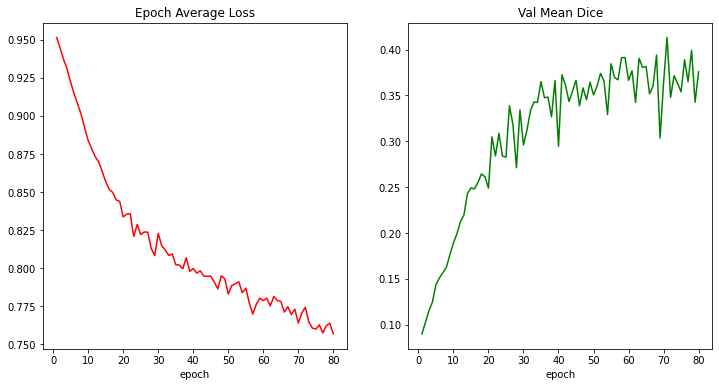

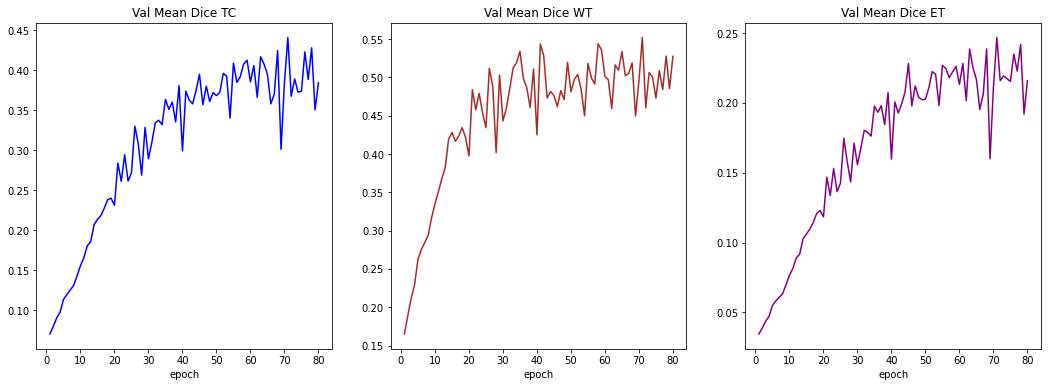

In [40]:
%matplotlib inline 
val_interval=1
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

In [ ]:
test_acc, test_loss = test_inference(args, global_model, test_dataset)
    
print(f' \n Results after {epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

    # Saving the objects train_loss and train_accuracy:
file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
    format(dataset, model, epochs, frac, iid,
            local_ep, local_bs)

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, train_accuracy], f)

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))




In [163]:
#PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
model = "UNET"
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
             format(dataset, model, epochs, frac,
                        iid, local_ep, local_bs))
    
# # Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
             format(dataset, model, epochs, frac,
                    iid, local_ep, local_bs))

FileNotFoundError: [Errno 2] No such file or directory: '../save/fed_brats_UNET_1_C[0.1]_iid[1]_E[1]_B[2]_loss.png'